In [1]:
# all imports
import argparse
import numpy as np
import pandas as pd
import models.autoencoder as vae
import models.credence as cred
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


In [2]:
# define function for showing probability distributions

def view_distribution(gt_df, generated_df, xnames, ynames, xsize = (30,30), ysize = (15,30)):

    # print(X[:,0].shape, generated_df[1]["X1"].shape)
    # print('true value range', X[:, 0].min(), X[:, 0].max())
    # print('gen value range', generated_df[0]["X1"].min(), generated_df[0]["X1"].max())
    #sns.scatterplot(y="Y0",x="T",data=generated_df[0])
    nrows = len(xnames)
    size = xsize
    fig,ax = plt.subplots(nrows=nrows,ncols=2, figsize=size)
    for i,xvar in enumerate(xnames):
        sns.kdeplot(gt_df[xvar], ax=ax[i,0], fill=True)
        ax[i,0].set_title(f'Observed {xvar}')
        sns.kdeplot(generated_df[xvar], ax=ax[i,1], fill=True)
        ax[i,1].set_title(f'Generated {xvar}')

    #plt.show()
    nrows = len(ynames)
    size = ysize
    fig,ax = plt.subplots(nrows=nrows,ncols=2,figsize=size)

    for i,yvar in enumerate(ynames):
        sns.kdeplot(gt_df[yvar], ax = ax[i,0], fill = True)
        ax[i,0].set_title(f'Observed {yvar}')
        sns.kdeplot(generated_df[yvar], ax = ax[i,1], fill = True)
        ax[i,1].set_title(f'Generated {yvar}')

    #plt.show()


In [3]:
# define datasets
#w = widgets.IntSlider()
datasets = ['acic19_linear', 'acic19_polynomial', 'toy']
w = widgets.Dropdown(
    options=datasets,
    value='acic19_linear',
    description='Dataset:',
)
display(w)
dataset_type = w.value

Dropdown(description='Dataset:', options=('acic19_linear', 'acic19_polynomial', 'toy'), value='acic19_linear')

/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.co ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/playground/nofl-pg/lightning_logs/version_25374230/checkpoints exists and is not empty.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 16     | train
1 | en_mu     | Linear     | 36     | train
2 | e

     V1  V2  V3  V4  V5    V6  V7     V8  V9  V10  A          Y       Y_cf
0    18   4  15   1   0   0.0   0   0.00   0  0.0  0  -0.273975   0.526025
1    15   1  14   1   0   0.0   0   0.00   0  0.0  0   0.310398   1.110398
2    52   5  16   4   1  37.0   1   3.00   0  0.0  0  11.271551  12.071551
3    46   3  21   4   0   0.0   1  15.00   0  0.0  1  11.981071  11.181071
4    42   3  23   2   0   0.0   0   0.00   0  0.0  0   8.838387   9.638387
..   ..  ..  ..  ..  ..   ...  ..    ...  ..  ... ..        ...        ...
663  34   3  18   0   0   0.0   0   0.00   0  0.0  0   2.741704   3.541704
664  32   2  19   1   0   0.0   1   8.00   0  0.0  0   2.853626   3.653626
665  25   2  17   0   0   0.0   1   0.08   0  0.0  0   0.974585   1.774585
666  33   2  24   2   0   0.0   1   0.08   0  0.0  1   3.224468   2.424468
667  29   2  20   1   0   0.0   1   0.50   0  0.0  0   2.036693   2.836693

[668 rows x 13 columns]
           V1        V2        V3        V4        V5        V6        V7  

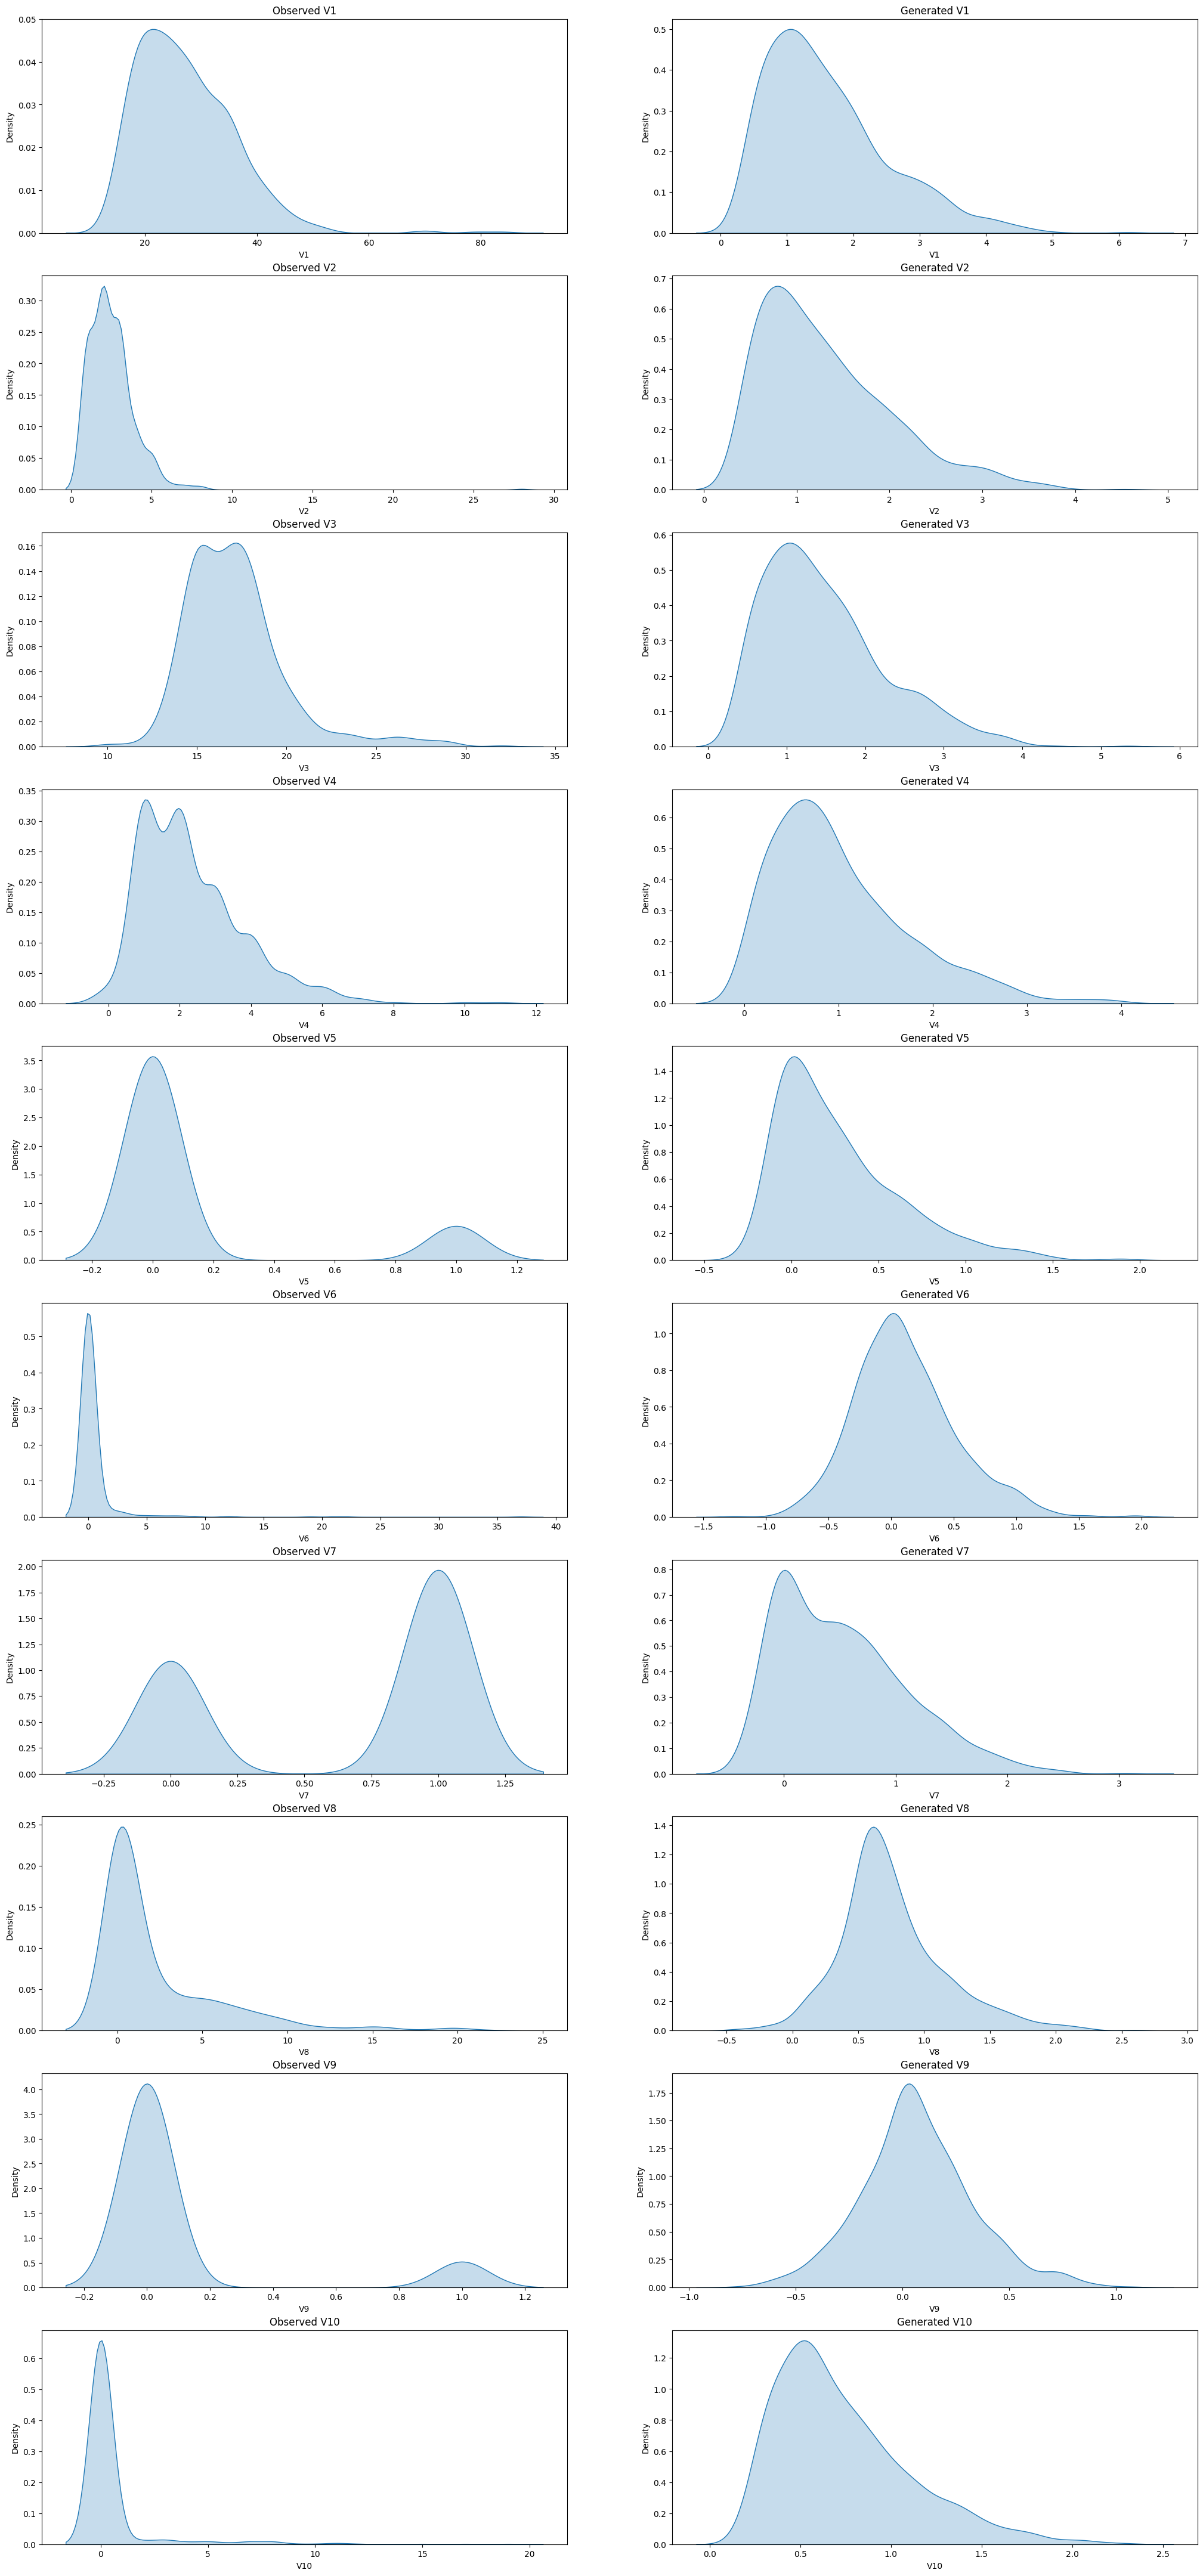

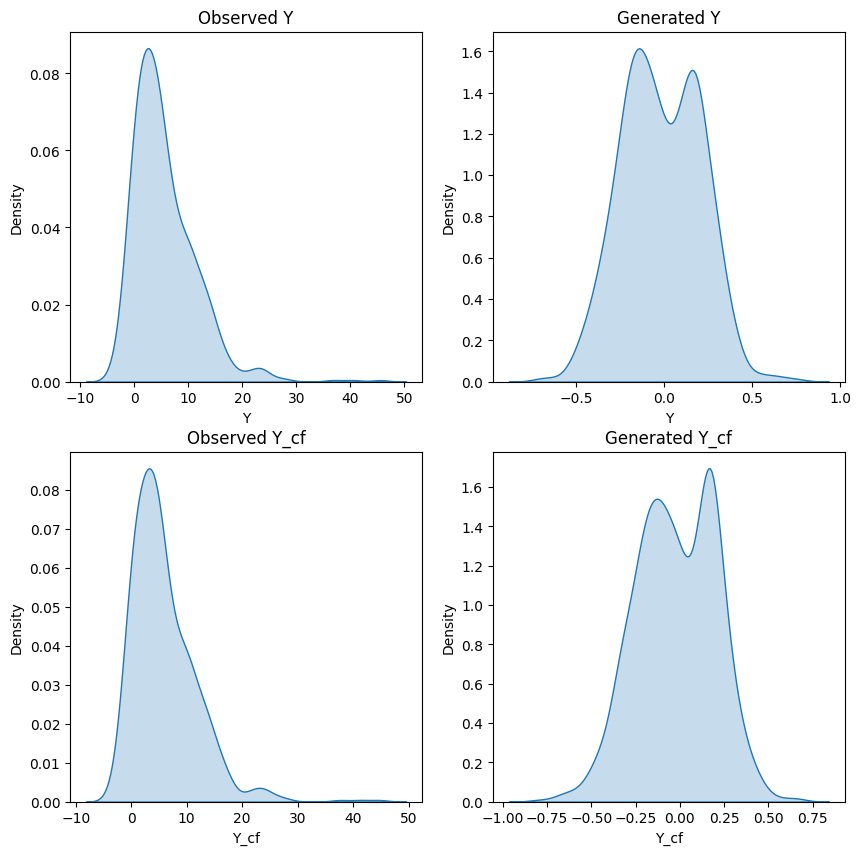

In [7]:
if dataset_type == 'toy':
    # generating toy dataset
    X = np.random.normal(0, 1, (2000, 5))
    Y0 = np.random.normal(np.sum(X,axis=1),1)
    T = np.random.binomial(1,0.5,size=(X.shape[0],))
    Y1 = Y0**2 + np.random.normal(np.mean(X,axis=1),5)
    Y = T*Y1 + (1 - T)*Y0
    xnames = ['X%d'%(i) for i in range(X.shape[1])]
    ynames = ['Y', 'Y_cf']

    df = pd.DataFrame(X, columns=['X%d'%(i) for i in range(X.shape[1])])
    df['Y'] = T*Y1 + (1 - T)*Y0
    df['T'] = T

    cred_obj = cred.Credence(
        data = df,
        outcome_var = ['Y'],
        treatment_var = ['T'],
        categorical_var = ['T'],
        numerical_var=['X%d'%(i) for i in range(X.shape[1])]+['Y']
    )
    gen_models = cred_obj.fit(kld_rigidity = 1.0, max_epochs = 5)

    # generate samples
    generated_df = cred_obj.sample()
    generated_df['Y'] = (generated_df['A'] * generated_df['Y1']) + ((1 - generated_df['A']) * generated_df['Y0'])
    generated_df['Y_cf'] = (generated_df['A'] * generated_df['Yprime1']) + ((1 - generated_df['A']) * generated_df['Yprime0'])
    observed = (X, Y, T)
    #print(generated_df)
    view_distribution(df, generated_df[1], xnames, ynames)
elif dataset_type == 'acic19_linear':
    gt_df = pd.read_csv('./data/datasets/acic19_low_dim_1_linear.csv')

    x_vars = ['V%d'%(i) for i in range(1,11)]
    y_vars = ['Y', 'Y_cf']

    cred_obj = cred.Credence(
        data = gt_df,
        outcome_var = ['Y'],
        treatment_var = ['A'],
        categorical_var = ['A'],
        numerical_var=x_vars+['Y']
    )
    gen_models = cred_obj.fit(kld_rigidity = 1.0, max_epochs = 5)

    # generated samples
    generated_df, generated_df_prime = cred_obj.sample()
    generated_df_prime['Y'] = (generated_df_prime['A'] * generated_df_prime['Y1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Y0'])
    generated_df_prime['Y_cf'] = (generated_df_prime['A'] * generated_df_prime['Yprime1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Yprime0'])
    print(gt_df)
    print(generated_df_prime)
    print(len(x_vars), len(y_vars))
    view_distribution(gt_df, generated_df_prime, x_vars, y_vars, (25,55), (10,10))
else:
    SystemExit('Invalid dataset value provided!')